In [352]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

import warnings

In [353]:
df = pd.read_csv('data/vehicles.csv')

In [354]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [355]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [320]:
df.describe()

,price,year,odometer
count,4.268800e+05,425675.000000,4.224800e+05
mean,7.519903e+04,2011.235191,9.804333e+04
std,1.218228e+07,9.452120,2.138815e+05
min,0.000000e+00,1900.000000,0.000000e+00
25%,5.900000e+03,2008.000000,3.770400e+04
50%,1.395000e+04,2013.000000,8.554800e+04
75%,2.648575e+04,2017.000000,1.335425e+05
max,3.736929e+09,2022.000000,1.000000e+07


In [356]:
df2 = df.dropna()
df2.info()
#If dropping all rows that have null values, only a little over 34k rows will be left so exploring other ways to remove null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34868 entries, 126 to 426836
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            34868 non-null  int64  
 1   region        34868 non-null  object 
 2   price         34868 non-null  int64  
 3   year          34868 non-null  float64
 4   manufacturer  34868 non-null  object 
 5   model         34868 non-null  object 
 6   condition     34868 non-null  object 
 7   cylinders     34868 non-null  object 
 8   fuel          34868 non-null  object 
 9   odometer      34868 non-null  float64
 10  title_status  34868 non-null  object 
 11  transmission  34868 non-null  object 
 12  VIN           34868 non-null  object 
 13  drive         34868 non-null  object 
 14  size          34868 non-null  object 
 15  type          34868 non-null  object 
 16  paint_color   34868 non-null  object 
 17  state         34868 non-null  object 
dtypes: float64(2), int64(2)

In [237]:
#Find out the null values in each column
df.isna().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [238]:
#drop any columns that don't impact sales and are unique to each car such as id, VIN that do not add anything to the model
#dropping state and region
df = df.drop(['id','region','VIN', 'state'], axis = 1)

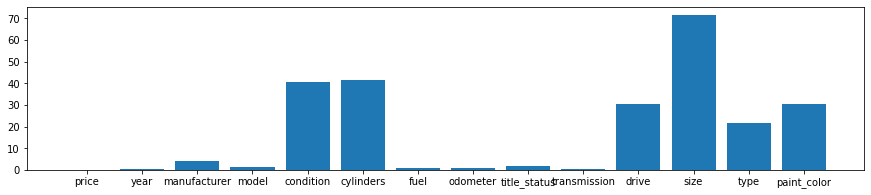

In [239]:
#What is the number of null in each column?
na_percentage = df.isna().sum() / df.shape[0] * 100

fig, ax = plt.subplots(figsize=[15, 3])
bars = ax.bar(x=df.columns, height=round(na_percentage, 2))

In [240]:
#remove all the data in size column since it has > 70% null data
#As will be seen later, this method allows more rows to be maintained, rather than dropna() which would drop many more rows and datapoints
df.drop(columns="size", inplace=True)


In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  drive         296313 non-null  object 
 11  type          334022 non-null  object 
 12  paint_color   296677 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 42.3+ MB


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

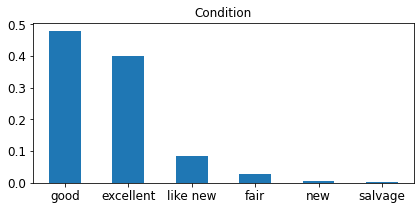

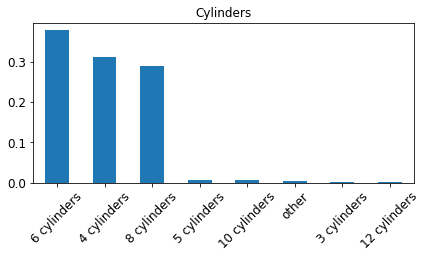

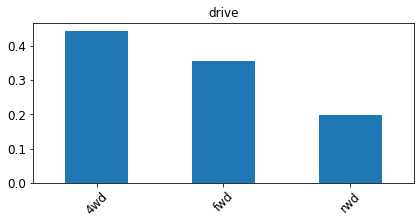

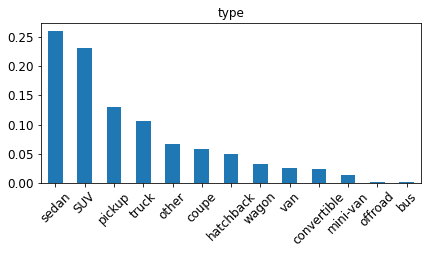

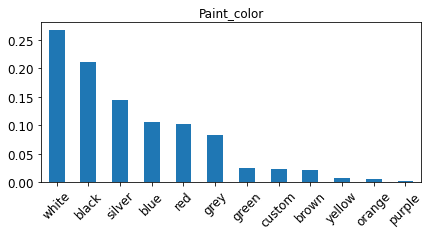

In [321]:
#Visualizing ghe dristribution of values across each column
#there is distribution across values so not dropping any column here
plt.subplots(figsize=(15,10))
plt.subplot(321)
df.condition.value_counts(100).plot(kind='bar', title="Condition", fontsize=18)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.subplots(figsize=(15,10))
plt.subplot(321)
df.cylinders.value_counts(100).plot(kind='bar', title="Cylinders", fontsize=18)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.subplots(figsize=(15,10))
plt.subplot(321)
df.drive.value_counts(100).plot(kind='bar', title="drive", fontsize=18)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.subplots(figsize=(15,10))
plt.subplot(321)
df.type.value_counts(100).plot(kind='bar', title="type", fontsize=18)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.subplots(figsize=(15,10))
plt.subplot(321)
df.paint_color.value_counts(100).plot(kind='bar', title="Paint_color", fontsize=18)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)



C:\Users\rsreenivsan\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\rsreenivsan\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\rsreenivsan\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function fo

<AxesSubplot:xlabel='year'>

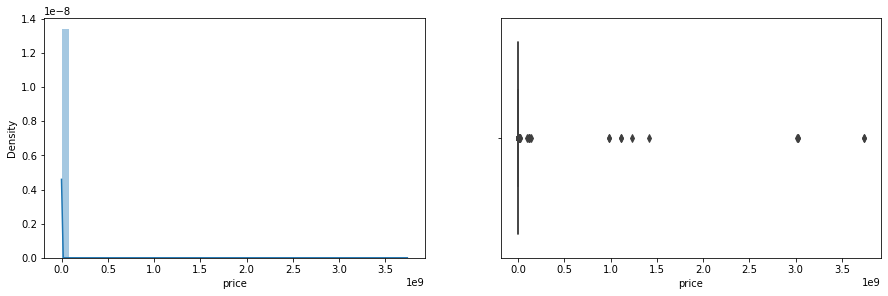

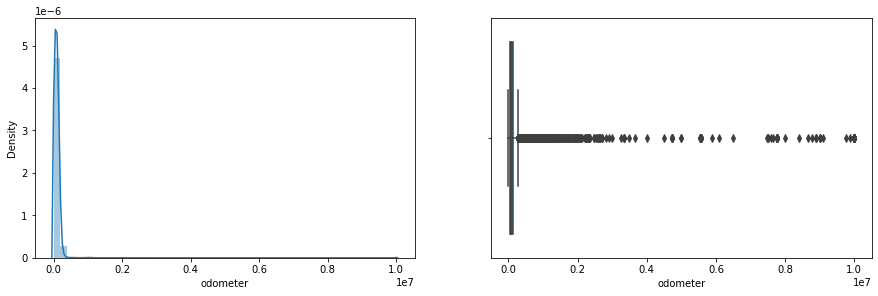

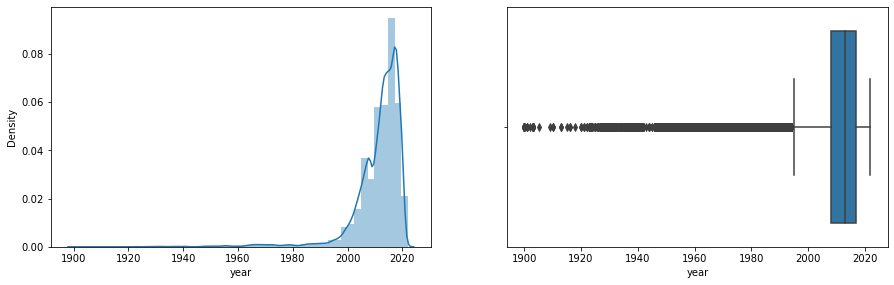

In [243]:
# Distribution of target variable 'price' by year and odometer
import seaborn as sns
plt.subplots(figsize=(15,15))
plt.subplot(321)
sns.distplot(df.price)
plt.subplot(322)
sns.boxplot(df.price)

plt.subplots(figsize=(15,15))
plt.subplot(321)
sns.distplot(df.odometer)
plt.subplot(322)
sns.boxplot(df.odometer)

plt.subplots(figsize=(15,15))
plt.subplot(321)
sns.distplot(df.year)
plt.subplot(322)
sns.boxplot(df.year)

In [244]:
#Find the distribution of 'price'
qnt = np.quantile(a=df.price, q=[0.04,0.1,0.25,0.5,0.75,0.99,0.995,0.9999,0.99999,1])
for q in qnt:
    print('{:.2f}'.format(q))

0.00
500.00
5900.00
13950.00
26485.75
66995.00
77000.00
1234567.00
2579623617.11
3736928711.00


In [322]:
#As can be seen, more than 99.5% of the data has prices less than 77000, hence keeping only those values for the final dataset
print(df[df['price'] < 77000].shape)


(424742, 13)


In [323]:
df1 = df[(df['price'] <= 77000)]

In [324]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424763 entries, 0 to 426879
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         424763 non-null  int64  
 1   year          423625 non-null  float64
 2   manufacturer  407493 non-null  object 
 3   model         419674 non-null  object 
 4   condition     252031 non-null  object 
 5   cylinders     248045 non-null  object 
 6   fuel          421759 non-null  object 
 7   odometer      420385 non-null  float64
 8   title_status  416568 non-null  object 
 9   transmission  422217 non-null  object 
 10  drive         294742 non-null  object 
 11  type          332391 non-null  object 
 12  paint_color   295260 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 45.4+ MB


In [325]:
df1.isna().sum()

price                0
year              1138
manufacturer     17270
model             5089
condition       172732
cylinders       176718
fuel              3004
odometer          4378
title_status      8195
transmission      2546
drive           130021
type             92372
paint_color     129503
dtype: int64

In [326]:
df1 = df1.dropna()

In [327]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115701 entries, 31 to 426878
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         115701 non-null  int64  
 1   year          115701 non-null  float64
 2   manufacturer  115701 non-null  object 
 3   model         115701 non-null  object 
 4   condition     115701 non-null  object 
 5   cylinders     115701 non-null  object 
 6   fuel          115701 non-null  object 
 7   odometer      115701 non-null  float64
 8   title_status  115701 non-null  object 
 9   transmission  115701 non-null  object 
 10  drive         115701 non-null  object 
 11  type          115701 non-null  object 
 12  paint_color   115701 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 12.4+ MB


In [251]:
count = (df1['price'] == 0).sum()
print('Count of zeros in Column  price : ', count)

count1 = (df1['odometer'] == 0).sum()
print('Count of zeros in odometer  column : ', count1)

Count of zeros in Column  price :  4352
Count of zeros in odometer  column :  244


In [252]:
# Removing records with zero for Odometer and Prices
# Remove rows with all 0s in a Dataframe
df1.drop(df1[df1['price'] == 0].index, inplace = True)
df1.drop(df1[df1['odometer'] == 0].index, inplace = True)
df1

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
31,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black
32,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8 cylinders,gas,68696.0,clean,other,4wd,pickup,black
33,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,4wd,pickup,silver
34,35000,2019.0,toyota,tacoma,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey
35,29990,2016.0,chevrolet,colorado extended cab,good,6 cylinders,gas,17302.0,clean,other,4wd,pickup,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426859,48590,2020.0,cadillac,xt6 premium luxury,good,6 cylinders,gas,7701.0,clean,other,fwd,other,black
426860,39990,2017.0,infiniti,qx80 sport utility 4d,good,8 cylinders,gas,41664.0,clean,automatic,4wd,other,black
426866,32990,2016.0,infiniti,qx80 sport utility 4d,good,8 cylinders,gas,55612.0,clean,automatic,rwd,other,black
426874,33590,2018.0,lexus,gs 350 sedan 4d,good,6 cylinders,gas,30814.0,clean,automatic,rwd,sedan,white


In [328]:
df1.eq(0).any()

price            True
year            False
manufacturer    False
model           False
condition       False
cylinders       False
fuel            False
odometer         True
title_status    False
transmission    False
drive           False
type            False
paint_color     False
dtype: bool

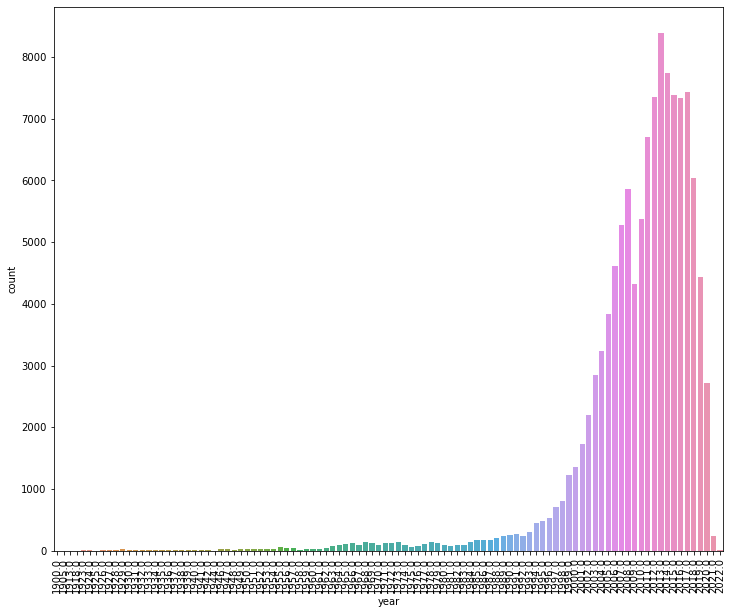

In [329]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,10))

df1['year'].value_counts()
ax = sns.countplot(x = 'year', data = df1, ax = ax)
plt.xticks(rotation=90)
plt.show()

#Since count of cars before 1970 is less, exclude data from earlier during model building possibly

In [255]:
df1['title_status'].value_counts()
#majorly clean

clean         105109
rebuilt         3499
salvage         1426
lien             857
missing          197
parts only        52
Name: title_status, dtype: int64

In [256]:
df1['transmission'].value_counts()
#majorly automatic

automatic    90909
other        12259
manual        7972
Name: transmission, dtype: int64

In [257]:
df1['cylinders'].value_counts()
#majorly 6/4/8 cylinders

6 cylinders     41375
4 cylinders     34384
8 cylinders     33080
5 cylinders       905
10 cylinders      847
other             291
3 cylinders       200
12 cylinders       58
Name: cylinders, dtype: int64

In [258]:
df1['model'].value_counts()
#too many values, can drop

f-150                       1724
silverado 1500              1465
1500                         955
camry                        861
accord                       833
                            ... 
tiguan wolfsburg               1
super duty f-250 xlt 4x4       1
cx-7 sv                        1
colorado lt 4x4                1
gand wagoneer                  1
Name: model, Length: 11135, dtype: int64

In [259]:
df1['paint_color'].value_counts()
#too many, can drop

white     26731
black     21052
silver    16135
blue      12189
red       12032
grey      11964
green      3528
brown      3180
custom     2448
yellow      901
orange      641
purple      339
Name: paint_color, dtype: int64

In [260]:
df1['manufacturer'].value_counts()
#too many, can drop

ford               19841
chevrolet          16851
toyota              9637
honda               6459
nissan              5981
jeep                5570
gmc                 4602
dodge               4027
ram                 3924
bmw                 3131
mercedes-benz       2808
subaru              2670
hyundai             2496
volkswagen          2292
lexus               2161
chrysler            1937
kia                 1913
cadillac            1624
buick               1501
infiniti            1419
mazda               1301
audi                1236
acura               1203
lincoln             1148
pontiac              908
mitsubishi           869
volvo                805
mini                 513
mercury              479
saturn               414
rover                402
jaguar               364
porsche              333
fiat                 168
alfa-romeo            45
tesla                 39
harley-davidson       31
datsun                22
land rover             8
aston-martin           5


In [261]:
df1['condition'].value_counts()


excellent    49156
good         45632
like new     11875
fair          3689
new            497
salvage        291
Name: condition, dtype: int64

In [262]:
df1['drive'].value_counts()
#too many, can drop

4wd    46902
fwd    38088
rwd    26150
Name: drive, dtype: int64

In [263]:
df1['fuel'].value_counts()
#too many, can drop

gas         101944
diesel        6010
other         1725
hybrid        1279
electric       182
Name: fuel, dtype: int64

In [264]:
df1.type.value_counts()

sedan          29869
SUV            26188
truck          14511
pickup         12398
coupe           7965
hatchback       4288
other           3296
van             3284
convertible     3221
wagon           2899
mini-van        2597
offroad          466
bus              158
Name: type, dtype: int64

In [291]:
df1 = df1.drop(['cylinders', 'manufacturer', 'model', 'paint_color', 'type'], axis = 1)

In [293]:
df1.title_status.value_counts()

clean         105109
rebuilt         3499
salvage         1426
lien             857
missing          197
parts only        52
Name: title_status, dtype: int64

In [294]:
df1.head()

,price,year,condition,fuel,odometer,title_status,transmission,drive
31,15000,2013.0,excellent,gas,128000.0,clean,automatic,rwd
32,27990,2012.0,good,gas,68696.0,clean,other,4wd
33,34590,2016.0,good,gas,29499.0,clean,other,4wd
34,35000,2019.0,excellent,gas,43000.0,clean,automatic,4wd
35,29990,2016.0,good,gas,17302.0,clean,other,4wd


In [295]:
#looking at the correlation
df1.corr()

,price,year,odometer
price,1.000000,0.349131,-0.209242
year,0.349131,1.000000,-0.157387
odometer,-0.209242,-0.157387,1.000000


In [296]:
#Transforming categorical data in columns condition, fuel, title_status, drive, transmission
df1_full =pd.get_dummies(df1, columns=["condition","fuel","title_status", "drive", "transmission"])
df1_full.head()

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,...,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,drive_4wd,drive_fwd,drive_rwd,transmission_automatic,transmission_manual,transmission_other
31,15000,2013.0,128000.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
32,27990,2012.0,68696.0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
33,34590,2016.0,29499.0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
34,35000,2019.0,43000.0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
35,29990,2016.0,17302.0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [297]:
df1_full.corr()

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,...,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,drive_4wd,drive_fwd,drive_rwd,transmission_automatic,transmission_manual,transmission_other
price,1.000000,0.349131,-0.209242,-0.083514,-0.174152,0.090511,0.089828,0.042753,-0.048001,0.240575,...,-0.034819,-0.021496,-0.031031,-0.054401,0.247263,-0.352323,0.106321,-0.302680,-0.070679,0.431049
year,0.349131,1.000000,-0.157387,0.030396,-0.199142,-0.012658,0.088931,0.017222,-0.035551,-0.008137,...,-0.108016,-0.028646,0.059227,0.003675,0.129676,0.093870,-0.256014,-0.020890,-0.264889,0.243922
odometer,-0.209242,-0.157387,1.000000,-0.004395,0.100206,-0.000315,-0.051596,-0.018993,0.031176,0.038780,...,0.028276,0.061902,-0.028209,0.000321,0.005467,0.005650,-0.012687,0.093966,0.033862,-0.143637
condition_excellent,-0.083514,0.030396,-0.004395,1.000000,-0.165005,-0.743252,-0.308012,-0.059685,-0.045628,0.008398,...,-0.028912,-0.011727,0.043412,-0.024903,0.027172,0.050504,-0.088146,0.230003,-0.011579,-0.273772
condition_fair,-0.174152,-0.199142,0.100206,-0.165005,1.000000,-0.154645,-0.064087,-0.012418,-0.009494,0.001225,...,0.074583,0.014572,-0.012409,0.031985,-0.014725,-0.003517,0.021079,0.005534,0.066841,-0.061874
condition_good,0.090511,-0.012658,-0.000315,-0.743252,-0.154645,1.000000,-0.288673,-0.055938,-0.042763,-0.008216,...,0.003964,-0.007908,-0.055056,-0.008368,-0.018446,-0.062593,0.091511,-0.298739,-0.012061,0.377911
condition_like new,0.089828,0.088931,-0.051596,-0.308012,-0.064087,-0.288673,1.000000,-0.023181,-0.017721,0.000496,...,-0.013190,-0.003443,0.024210,0.000682,-0.005564,0.019479,-0.015316,0.101344,-0.007764,-0.118437
condition_new,0.042753,0.017222,-0.018993,-0.059685,-0.012418,-0.055938,-0.023181,1.000000,-0.003434,-0.005292,...,0.003588,0.004786,0.002589,0.003143,0.000345,0.002749,-0.003478,0.006804,0.016384,-0.021877
condition_salvage,-0.048001,-0.035551,0.031176,-0.045628,-0.009494,-0.042763,-0.017721,-0.003434,1.000000,-0.002909,...,0.056442,0.153586,0.001854,0.202233,-0.001713,0.002698,-0.001025,-0.000469,0.019874,-0.015792
fuel_diesel,0.240575,-0.008137,0.038780,0.008398,0.001225,-0.008216,0.000496,-0.005292,-0.002909,1.000000,...,-0.005346,-0.003333,-0.004149,-0.008877,0.135951,-0.146240,0.005338,0.055572,0.003840,-0.071615


<AxesSubplot:>

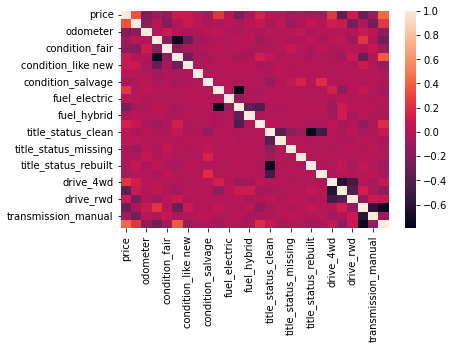

In [330]:
sns.heatmap(df1_full.corr())

In [331]:
#Model Building
#Split the dataset into 70-30 train and test datasets
X = df1_full.drop(['price'], axis =1)
y = df1_full.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


In [333]:
#Linear regression model
model = LinearRegression(fit_intercept = False)


In [334]:
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [335]:
print("Coefficient of the model: ",model.coef_)
print("Intercept of the model: ", model.intercept_)

Coefficient of the model:  [ 3.43819847e+02 -7.42937253e-03 -9.22320941e+04 -9.89729015e+04
 -9.34488221e+04 -8.85389004e+04 -8.33877137e+04 -9.84257799e+04
 -1.02985849e+05 -1.10246568e+05 -1.15974869e+05 -1.16423310e+05
 -1.09375616e+05 -9.28154031e+04 -8.93901675e+04 -9.09430415e+04
 -9.23149034e+04 -9.39573859e+04 -9.55853104e+04 -1.82840989e+05
 -1.90354325e+05 -1.81810899e+05 -1.90165437e+05 -1.88441049e+05
 -1.76399725e+05]
Intercept of the model:  0.0


In [336]:
train_predict = model.predict(X_train)

In [337]:
train_predict

array([19897.41360831, 12511.66662703, 17186.35992584, ...,
       10857.76638465,  9913.90437567, 15290.00329224])

In [338]:
score = model.score(X_train, y_train)

In [339]:
#Computing accuracy and RMSe of training model 
print ("Model score is:", round(score,2))
print ("MSE is:",round(np.sqrt(mean_squared_error(y_train, train_predict)),2))

Model score is: 0.45
MSE is: 9424.89


In [340]:
#Testing on test dataset
test_predict = model.predict(X_test)

In [341]:
mse = mean_squared_error(test_predict, y_test)
print ("MSE:", mse)

MSE: 87708990.29611328


In [342]:
coef = model.coef_
coef_norm = coef /coef.sum()

In [343]:
columns_=list(df1_full.columns)
columns_.remove('price')

In [344]:
for i, feature in enumerate (columns_):
    print (feature, coef_norm[i])

year -0.00012391300940988985
odometer 2.677553134534345e-09
condition_excellent 0.03324053701435766
condition_fair 0.03566993060098863
condition_good 0.03367904697796227
condition_like new 0.03190950638799316
condition_new 0.03005301365280769
condition_salvage 0.03547274743226186
fuel_diesel 0.03711620073933239
fuel_electric 0.03973297093054285
fuel_gas 0.041797456447074735
fuel_hybrid 0.041959074787374234
fuel_other 0.03941907916204768
title_status_clean 0.03345076212979171
title_status_lien 0.032216303875108605
title_status_missing 0.03277596119056167
title_status_parts only 0.03327038154476218
title_status_rebuilt 0.033862333880155124
title_status_salvage 0.03444903944599277
drive_4wd 0.06589607131405222
drive_fwd 0.0686038849265043
drive_rwd 0.06552482582581419
transmission_automatic 0.06853580979879989
transmission_manual 0.06791433858737946
transmission_other 0.06357463368019145


In [345]:
#the linear regression model indicates that transmission and drive affect the cost more than any other variable

In [314]:
#Linear regression with polynomial features
# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit the linear regression model on the polynomial features
lr_model = LinearRegression()
lr_model.fit(X_train_poly, y_train)

# Predict on the test set and evaluate the model
y_pred = lr_model.predict(X_test_poly)
r2 = r2_score(y_test, y_pred)
print('R^2 score:', r2)

R^2 score: 0.6320909480590462


In [315]:
# Linear Regression from polynomial features
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Linear Regression R^2 score:', r2)
print('Linear Regression feature importance:')
print(pd.Series(lr_model.coef_, index=columns_).sort_values(ascending=False))

Linear Regression R^2 score: 0.4547062475442165
Linear Regression feature importance:
condition_new              9113.321595
transmission_other         8602.345321
fuel_diesel                8015.393526
condition_like new         3962.134880
drive_rwd                  3191.172046
title_status_lien          3110.867805
drive_4wd                  2161.081925
fuel_other                 1625.626137
title_status_missing       1557.993790
fuel_electric               754.674650
year                        343.819847
condition_excellent         268.941177
title_status_parts only     186.131939
odometer                     -0.007429
title_status_clean         -314.367770
condition_good             -947.786827
title_status_rebuilt      -1456.350657
title_status_salvage      -3084.275108
transmission_manual       -3438.978538
fuel_gas                  -4973.626983
transmission_automatic    -5163.366782
drive_fwd                 -5352.253971
fuel_hybrid               -5422.067330
condition_salvage

In [348]:
#Ridge regression with Grid Search CV
ridge_param_dict = {'ridge__alpha': np.logspace(0, 10, 50)}
ridge_pipe = Pipeline([('scaler', StandardScaler()), 
                      ('ridge', Ridge())])
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict)
ridge_grid.fit(X_train, y_train)
ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)
r2 = r2_score(y_test, ridge_test_preds)
### END SOLUTION

# ANSWER CHECK
print(f'Train MSE: {ridge_train_mse}')
print(f'Test MSE: {ridge_test_mse}')
print(f'R2 score: {r2}')


Train MSE: 88829493.79599875
Test MSE: 87713683.5810082
R2 score: 0.45467706901960947


In [ ]:
#With the linear regression model, the Test MSE was high. The model score was 0.45, with year, odometer being less important than transmission and drive of the car
#With linear regression with polynomial features, the model score was higher, 0.65 with the condition of the car being new, fuel type diesel and drive as rwd being most important for the price
#With Ridge regression using GridsearchCV, the R2 score was lower - 0.45

#While this is not an extensive analysis, it indicates that the condition of the car being new or like new, the transmission type and the fuel type have an impact on the price of the car
#Dealerships should pay attention to these features while determining price of car